# Multivariate Linear Regression and Sentiment Analysis using Amazon.

### Overview

This project source code file analyzes amazon stock data using technical indicators retireeved from Alpha Vantage. Then, a multivariate linear regression model is used to see which of those technical indicators is the best predictor of stock closing price. Moreover, through the power of natural language processing, sentiment analysis using twitter's API was done to see how public opinion affects the closing price, and whether the two models are related. 

## ------------------------------------------------------------------------------------------------------------------------------

Importing all the libraries required for the project.

In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import seaborn as sb
import nltk
sb.set()
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
finwiz_url = 'https://finviz.com/quote.ashx?t='

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.techindicators import TechIndicators
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Neel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pip install alpha_vantage

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


# Utility Code to get datasets

Function to get the basic stock prices(open,close,high,low) of a company's stock

In [4]:
def get_intraday():
  key = '84E88MB3ZLGNJO2H'
  outputsize = 'compact'
  symbol = input('Ticker : ')
  typ = input('Data type- "daily", "weekly", "monthly", "interval" : ')

  ts = TimeSeries(key,output_format='pandas')

  if typ == 'daily':
    state = ts.get_daily_adjusted(symbol,outputsize=outputsize)[0]
  elif typ == 'weekly':
    state = ts.get_weekly_adjusted(symbol)[0]
  elif typ == 'monthly':
    state = ts.get_monthly_adjusted(symbol)[0]
  elif typ == 'interval':
    interval = input('Interval-1min, 5min, 15min, 30min, 60min : ')
    state = ts.get_intraday(symbol, interval=interval, outputsize=outputsize)[0]
  else:
    print('Wrong entry')
  return state

Function to get the fundamental data(income statement,balance sheet,etc.) of a company

In [5]:
def get_fundamental():
  key = '84E88MB3ZLGNJO2H'
  symbol = input('Ticker : ')
  period = input('Period- annual, quarterly : ')
  statement = input('Statement- balance sheet, income statement, cash flow : ')

  fd = FundamentalData(key,output_format = 'pandas')

  if period == 'annual':
    if statement == 'balance sheet':
      state = fd.get_balance_sheet_annual(symbol)[0].T[2:]
      state.columns = list(fd.get_balance_sheet_annual(symbol)[0].T.iloc[0])
    elif statement == 'income statement':
      state = fd.get_income_statement_annual(symbol)[0].T[2:]
      state.columns = list(fd.get_income_statement_annual(symbol)[0].T.iloc[0])
    elif statement == 'cash flow':
      state = fd.get_cash_flow_annual(symbol)[0].T[2:]
      state.columns = list(fd.get_cash_flow_annual(symbol)[0].T.iloc[0])
    else:
      print('Wrong Entry')

  elif period == 'quarterly':
    if statement == 'balance sheet':
      state = fd.get_balance_sheet_quarterly(symbol)[0].T[2:]
      state.columns = list(fd.get_balance_sheet_quarterly(symbol)[0].T.iloc[0])
    elif statement == 'income statement':
      state = fd.get_income_statement_quarterly(symbol)[0].T[2:]
      state.columns = list(fd.get_income_statement_quarterly(symbol)[0].T.iloc[0])
    elif statement == 'cash flow':
      state = fd.get_cash_flow_quarterly(symbol)[0].T[2:]
      state.columns = list(fd.get_cash_flow_quarterly(symbol)[0].T.iloc[0])
    else:
          print('Wrong Entry')
  return state

Function to get the technical indicators(SMA,EMA,VWAP,etc.) of a company

In [6]:
def get_tech():
  key = '84E88MB3ZLGNJO2H'
  symbol = input('Ticker : ')
  outputsize = 'compact'
  interval =input('Interval- 1min,5min,15min,30min,60min,daily,weekly,monthly : ')
  time = input('Time Period : ')
  tech_indi = input('Technical Indicator- SMA,EMA,VWAP,MACD,Stochastic Oscillator,RSI,Bollinger bands :')

  ti = TechIndicators(key,output_format='pandas')

  if tech_indi == 'SMA':
    state = ti.get_sma(symbol, interval=interval, time_period=time, series_type='close')[0]
  elif tech_indi == 'EMA':
    state = ti.get_ema(symbol, interval=interval, time_period=time, series_type='close')[0]
  elif tech_indi == 'VWAP':
    state = ti.get_vwap(symbol, interval=interval)[0]
  elif tech_indi == 'MACD':
    state = ti.get_macd(symbol, interval=interval, series_type='close')[0]
  elif tech_indi == 'Stochastic Oscillator':
    state = ti.get_stoch(symbol, interval=interval)[0]
  elif tech_indi == 'RSI':
    state = ti.get_rsi(symbol, interval=interval, time_period=time, series_type='close')[0]
  elif tech_indi == 'Bollinger bands':
    state = ti.get_bbands(symbol, interval=interval, time_period=time, series_type='close')[0]
  else:
    print('Wrong Entry')
  return state

# Importing of relevant datasets required

In [7]:
#get Amazon daliy stock info
amzn_daily = get_intraday()
amzn_daily.info()
amzn_daily.head()

Ticker : AMZN
Data type- "daily", "weekly", "monthly", "interval" : daily
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2021-04-22 to 2020-11-27
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               100 non-null    float64
 1   2. high               100 non-null    float64
 2   3. low                100 non-null    float64
 3   4. close              100 non-null    float64
 4   5. adjusted close     100 non-null    float64
 5   6. volume             100 non-null    float64
 6   7. dividend amount    100 non-null    float64
 7   8. split coefficient  100 non-null    float64
dtypes: float64(8)
memory usage: 7.0 KB


,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2021-04-22,3371.68,3372.8700,3301.4500,3309.04,3309.04,2580590.0,0.0,1.0
2021-04-21,3316.00,3362.8600,3303.8061,3362.02,3362.02,2211166.0,0.0,1.0
2021-04-20,3373.60,3382.9900,3316.0000,3334.69,3334.69,2623032.0,0.0,1.0
2021-04-19,3390.33,3435.9333,3360.1600,3372.01,3372.01,2725405.0,0.0,1.0
2021-04-16,3380.00,3406.8000,3355.5900,3399.44,3399.44,3186049.0,0.0,1.0


In [8]:
#extract only CLOSE from amzn_daily
amzn_close=pd.DataFrame(amzn_daily['4. close'])
amzn_close.info()
amzn_close.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2021-04-22 to 2020-11-27
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   4. close  100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


,4. close
date,
2021-04-22,3309.04
2021-04-21,3362.02
2021-04-20,3334.69
2021-04-19,3372.01
2021-04-16,3399.44


In [10]:
#get Techincal indicator - EMA
amzn_ema=get_tech()
amzn_ema.info()
amzn_ema.head()

Ticker : AMZN
Interval- 1min,5min,15min,30min,60min,daily,weekly,monthly : daily
Time Period : 5
Technical Indicator- SMA,EMA,VWAP,MACD,Stochastic Oscillator,RSI,Bollinger bands :EMA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5399 entries, 1999-11-05 to 2021-04-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA     5399 non-null   float64
dtypes: float64(1)
memory usage: 84.4 KB


,EMA
date,
1999-11-05,65.8760
1999-11-08,69.9173
1999-11-09,70.2149
1999-11-10,70.8099
1999-11-11,71.5400


In [11]:
#get Technical indicator - SMA
amzn_sma=get_tech()
amzn_sma.info()
amzn_sma.head()

Ticker : AMZN
Interval- 1min,5min,15min,30min,60min,daily,weekly,monthly : daily
Time Period : 5
Technical Indicator- SMA,EMA,VWAP,MACD,Stochastic Oscillator,RSI,Bollinger bands :SMA
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5399 entries, 1999-11-05 to 2021-04-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMA     5399 non-null   float64
dtypes: float64(1)
memory usage: 84.4 KB


,SMA
date,
1999-11-05,65.876
1999-11-08,67.650
1999-11-09,68.524
1999-11-10,69.762
1999-11-11,71.750


In [12]:
#manipulation of individaul datasets for combination in later part 
amzn_close['ticks'] = range(1,len(amzn_close.index.values)+1)
lastweekclose=amzn_close[amzn_close.ticks<=7]
amzn_close=amzn_close.reindex(index=amzn_close.index[::-1])
amzn_close=amzn_close.drop('ticks',axis=1)
amzn_close['ticks'] = range(1,len(amzn_close.index.values)+1)

amzn_sma['Ticks'] = range(1,len(amzn_sma.index.values)+1)
amzn_sma=amzn_sma[amzn_sma.Ticks>=5299]
amzn_sma=amzn_sma.drop('Ticks',axis=1)
amzn_sma['Ticks'] = range(1,len(amzn_sma.index.values)+1)

amzn_ema['Ticks1'] = range(1,len(amzn_ema.index.values)+1)
amzn_ema=amzn_ema[amzn_ema.Ticks1>=5299]
amzn_ema=amzn_ema.drop('Ticks1',axis=1)
amzn_ema['Ticks1']=range(1,len(amzn_ema.index.values)+1)


close = amzn_close
ema = amzn_ema
sma = amzn_sma

In [13]:
close

,4. close,ticks
date,,
2020-11-27,3195.34,1
2020-11-30,3168.04,2
2020-12-01,3220.08,3
2020-12-02,3203.53,4
2020-12-03,3186.73,5
...,...,...
2021-04-16,3399.44,96
2021-04-19,3372.01,97
2021-04-20,3334.69,98


In [14]:
sma

,SMA,Ticks
date,,
2020-11-25,3123.588,1
2020-11-27,3139.252,2
2020-11-30,3152.980,3
2020-12-01,3177.318,4
2020-12-02,3194.412,5
...,...,...
2021-04-16,3378.184,97
2021-04-19,3376.708,98
2021-04-20,3363.646,99


In [15]:
ema

,EMA,Ticks1
date,,
2020-11-25,3136.3242,1
2020-11-27,3155.9962,2
2020-11-30,3160.0108,3
2020-12-01,3180.0339,4
2020-12-02,3187.8659,5
...,...,...
2021-04-16,3368.4423,97
2021-04-19,3369.6315,98
2021-04-20,3357.9844,99


In [16]:
#creating joint dataframe with all the variables obtained
jointDF = pd.concat([ema,sma,close], axis = 1)
jointDF=jointDF.drop(jointDF.index[0])
tempDF = jointDF
tempDF = tempDF.drop(['Ticks','Ticks1','ticks'],axis=1)
tempDF.columns=['EMA','SMA','CLOSE']
tempDF.info()
tempDF.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2020-11-27 to 2021-04-22
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA     100 non-null    float64
 1   SMA     100 non-null    float64
 2   CLOSE   100 non-null    float64
dtypes: float64(3)
memory usage: 3.1 KB


,EMA,SMA,CLOSE
date,,,
2020-11-27,3155.9962,3139.252,3195.34
2020-11-30,3160.0108,3152.980,3168.04
2020-12-01,3180.0339,3177.318,3220.08
2020-12-02,3187.8659,3194.412,3203.53
2020-12-03,3187.4873,3194.744,3186.73


# Plots of the Closing price and technical indicators against dates

<AxesSubplot:xlabel='date'>

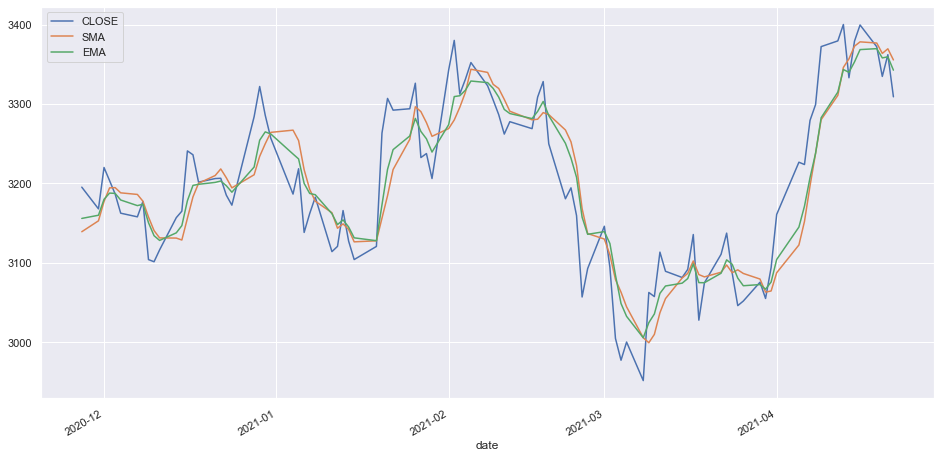

In [17]:
#ploting time series of all variables
tempDF[['CLOSE','SMA','EMA']].plot(label='AMZN',figsize=(16,8))

In [18]:
amzn_close['Rolling_Mean'] = amzn_close['4. close'].rolling(window = 5).mean()
amzn_close.head(5)

,4. close,ticks,Rolling_Mean
date,,,
2020-11-27,3195.34,1,NaN
2020-11-30,3168.04,2,NaN
2020-12-01,3220.08,3,NaN
2020-12-02,3203.53,4,NaN
2020-12-03,3186.73,5,3194.744


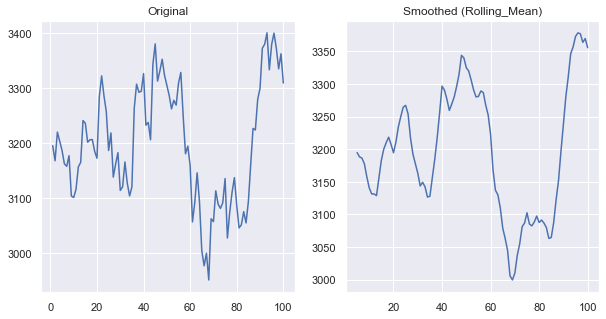

In [19]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5));
axes[0].plot('ticks', '4. close', data = amzn_close);
axes[0].set_title('Original')
axes[1].plot('ticks', 'Rolling_Mean', data = amzn_close);
axes[1].set_title('Smoothed (Rolling_Mean)');

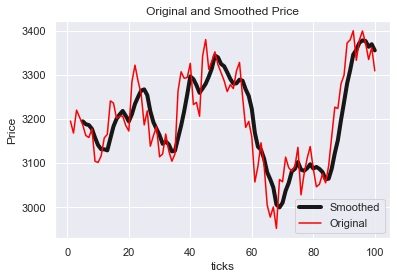

In [20]:
fig = plt.figure();
ax = fig.add_subplot(111);
ax.plot(amzn_close['ticks'], amzn_close['Rolling_Mean'], color = (0,0,0), linewidth = 4, alpha = .9, label = 'Smoothed');
ax.plot(amzn_close['ticks'], amzn_close['4. close'], color = (1,0,0), label = 'Original');
ax.set_title('Original and Smoothed Price')
ax.set_xlabel('ticks')
ax.set_ylabel('Price')
ax.legend(loc='lower right');

<AxesSubplot:xlabel='date'>

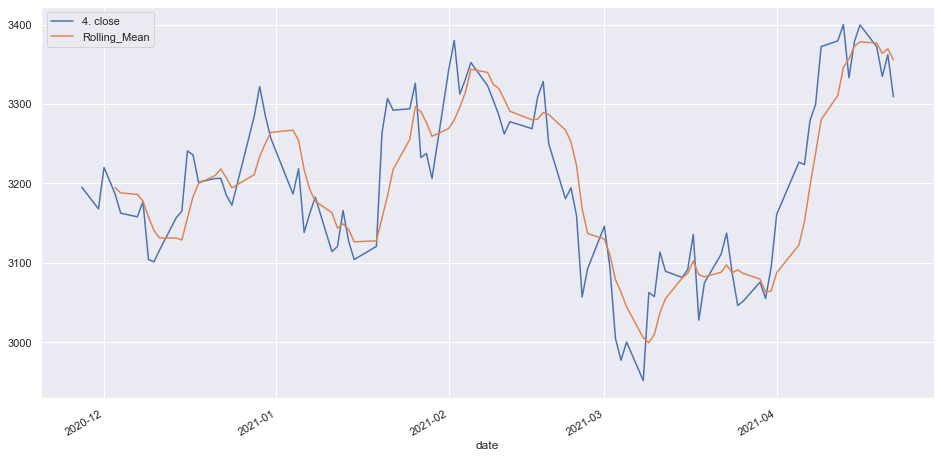

In [21]:
amzn_close[['4. close','Rolling_Mean']].plot(label='AMZN',figsize=(16,8))

# Exploratory Analysis on the variables obtained

In [22]:
#statistical analysis of variables
tempDF.describe()

,EMA,SMA,CLOSE
count,100.000000,100.000000,100.000000
mean,3195.172063,3195.350960,3199.296900
std,92.855277,96.804861,106.973344
min,3005.835900,2999.566000,2951.950000
25%,3130.761400,3127.512500,3114.055000
50%,3187.676600,3190.357000,3190.615000
75%,3267.561400,3277.348000,3287.992500
max,3369.631500,3378.184000,3400.000000


Plots to describe each independent variable

<AxesSubplot:>

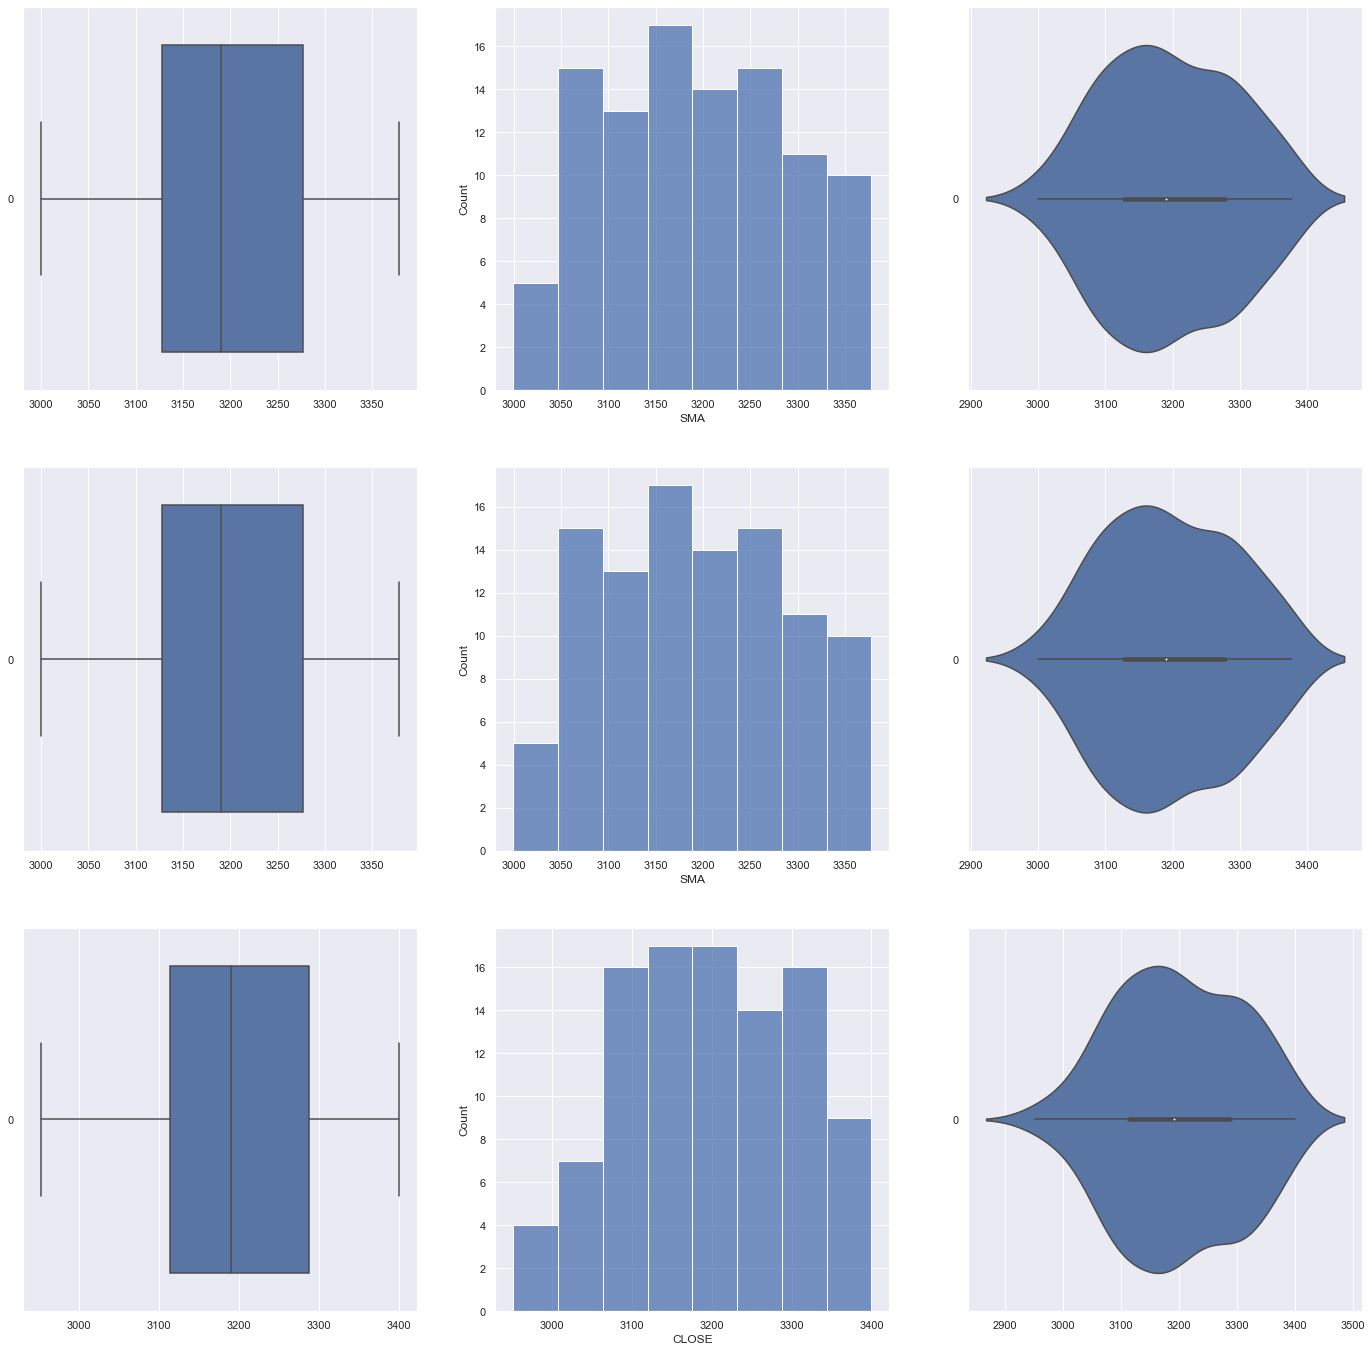

In [23]:
#uni-Variate description of individual variables
f, axes = plt.subplots(3, 3, figsize=(24, 24))

# Plot the basic uni-variate figures for SMA
sb.boxplot(data = tempDF['SMA'], orient = "h", ax = axes[0,0])
sb.histplot(data = tempDF['SMA'], ax = axes[0,1])
sb.violinplot(data = tempDF['SMA'], orient = "h", ax = axes[0,2])

# Plot the basic uni-variate figures for EMA
sb.boxplot(data = tempDF['SMA'], orient = "h", ax = axes[1,0])
sb.histplot(data = tempDF['SMA'], ax = axes[1,1])
sb.violinplot(data = tempDF['SMA'], orient = "h", ax = axes[1,2])

# Plot the basic uni-variate figures for 4. close
sb.boxplot(data = tempDF['CLOSE'], orient = "h", ax = axes[2,0])
sb.histplot(data = tempDF['CLOSE'], ax = axes[2,1])
sb.violinplot(data = tempDF['CLOSE'], orient = "h", ax = axes[2,2])

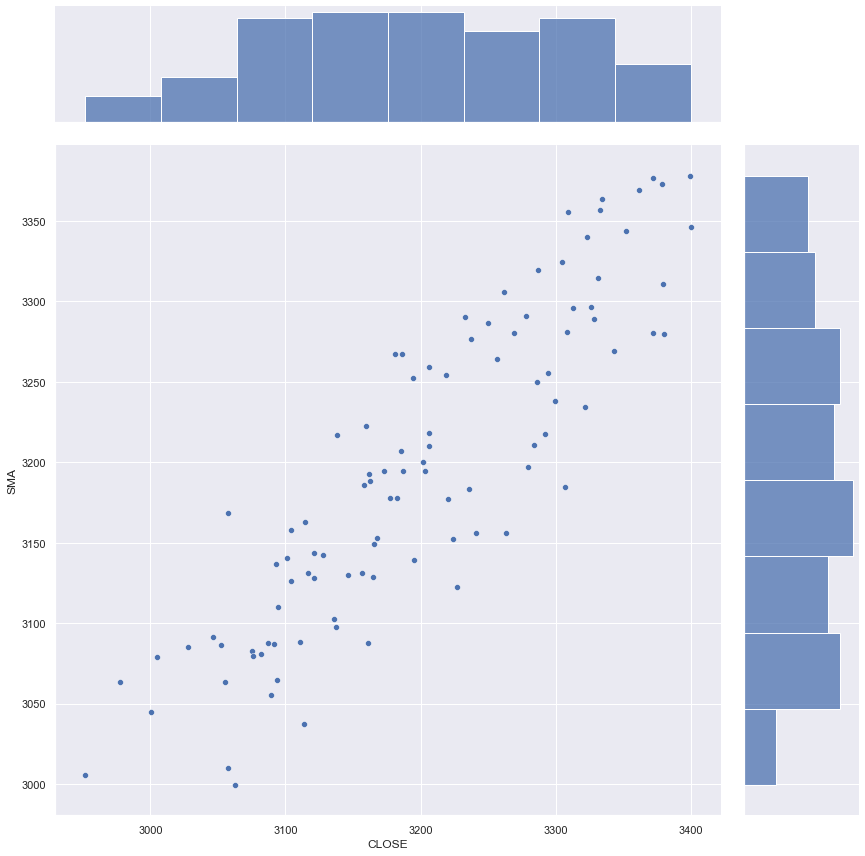

In [24]:
#jointplot for SMA vs CLOSE
sb.jointplot(data = tempDF, x = "CLOSE", y = "SMA", height = 12)

<Figure size 864x576 with 0 Axes>

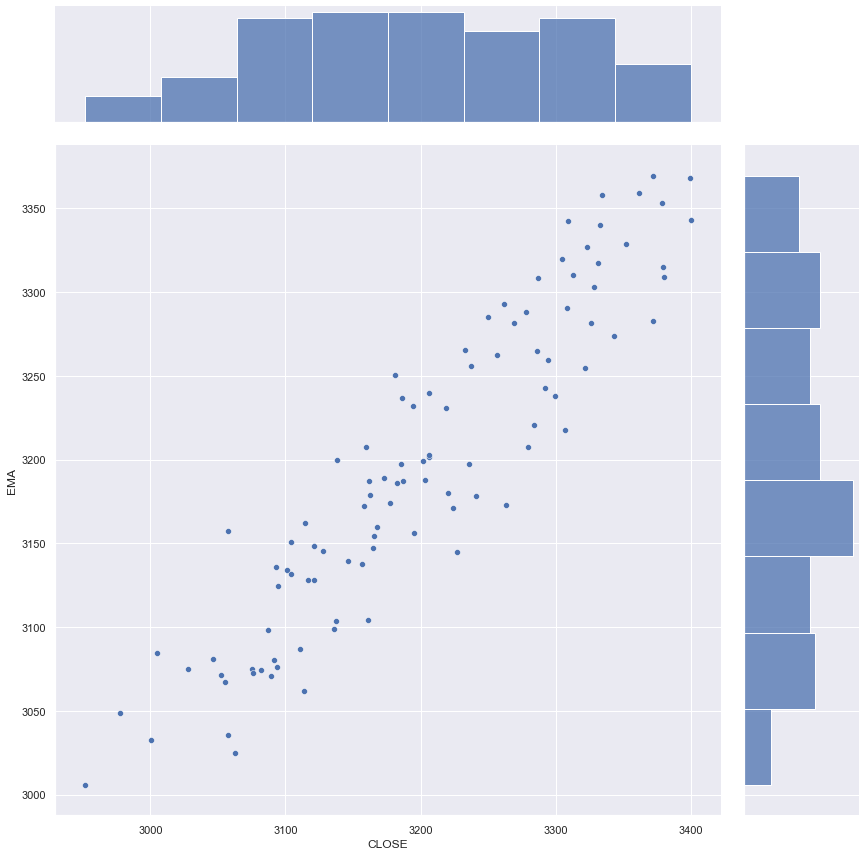

In [25]:
#jointplot of EMA vs CLOSE
f = plt.figure(figsize=(12, 8))
sb.jointplot(data = tempDF, x = "CLOSE", y = "EMA", height = 12)

In [26]:
#print correlation matrix
tempDF.corr()

,EMA,SMA,CLOSE
EMA,1.000000,0.990768,0.928028
SMA,0.990768,1.000000,0.885281
CLOSE,0.928028,0.885281,1.000000


<AxesSubplot:>

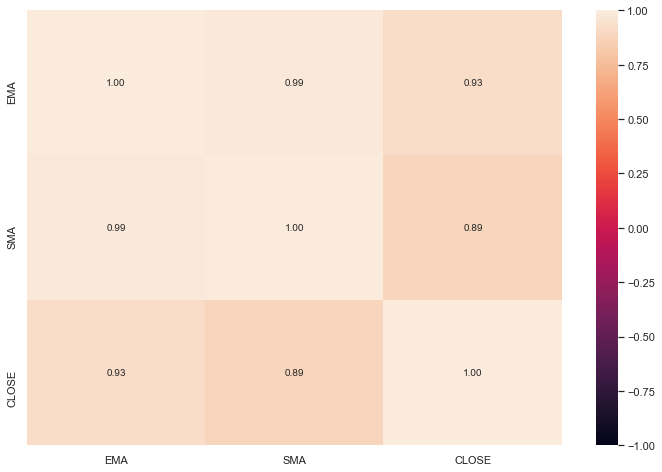

In [27]:
#heatmap for visualisation of correlation materix on variables
f = plt.figure(figsize=(12, 8))
sb.heatmap(tempDF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

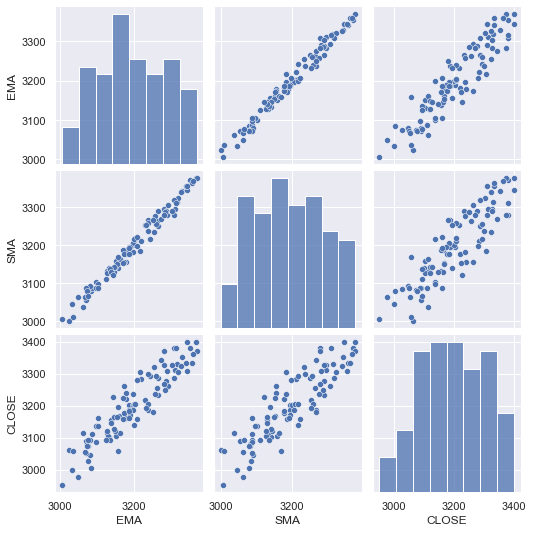

In [28]:
#pairplots of variables 
sb.pairplot(data = tempDF)

# Machine Learning on Dataset

In [29]:
#extrraction of X and Y vraribles for regression
y = pd.DataFrame(tempDF["CLOSE"])
X = pd.DataFrame(tempDF[["SMA","EMA"]])

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)
print("\n")

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Print the Coefficients against Predictors
pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"])

Train Set : (80, 1) (80, 2)
Test Set  : (20, 1) (20, 2)


Intercept of Regression 	: b =  [-472.33542431]
Coefficients of Regression 	: a =  [[-1.91800736  3.06682915]]



,Predictors,Coefficients
0,SMA,-1.918007
1,EMA,3.066829


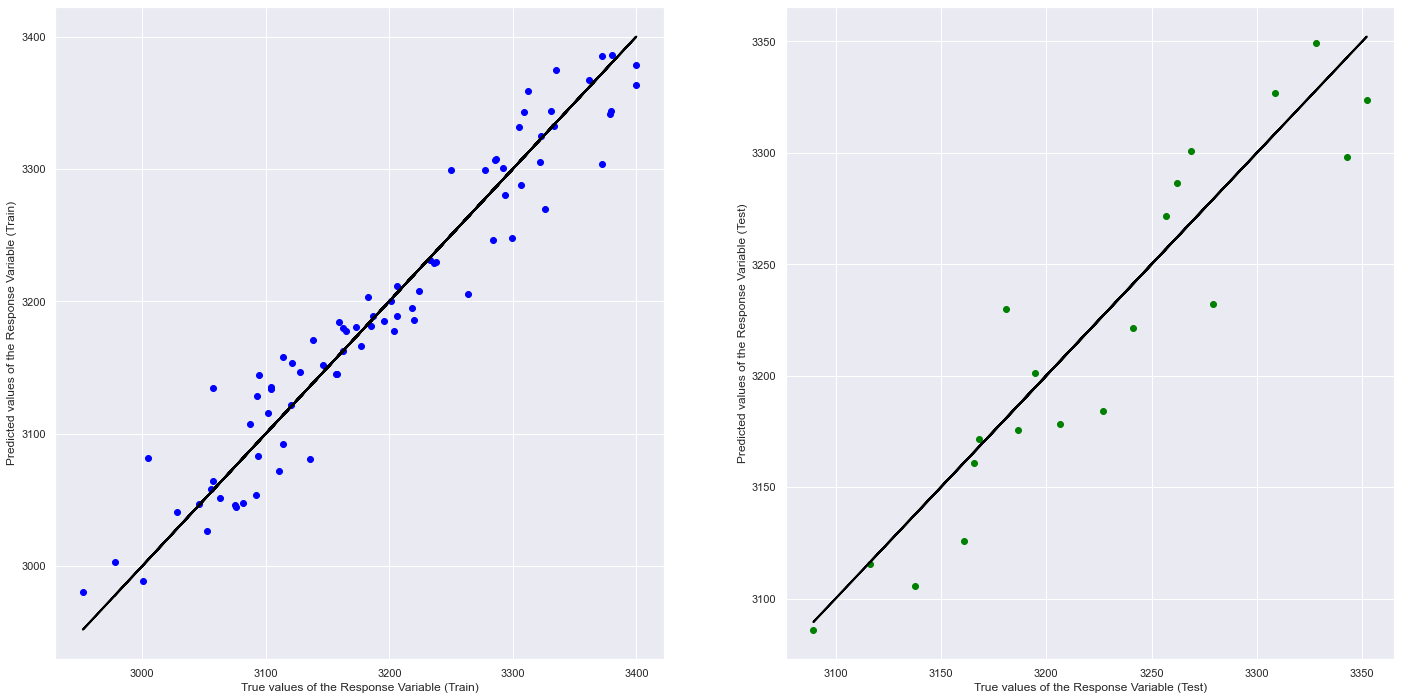

In [30]:
#Multi-Variate Regression
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 2, color = "black")
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 2 , color = "black")
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

Intercept of Regression 	: b =  [-281.00149364]
Coefficients of Regression 	: a =  [[-1.97866737  3.06774909]]

  Predictors  Coefficients
0        SMA     -1.978667
1        EMA      3.067749



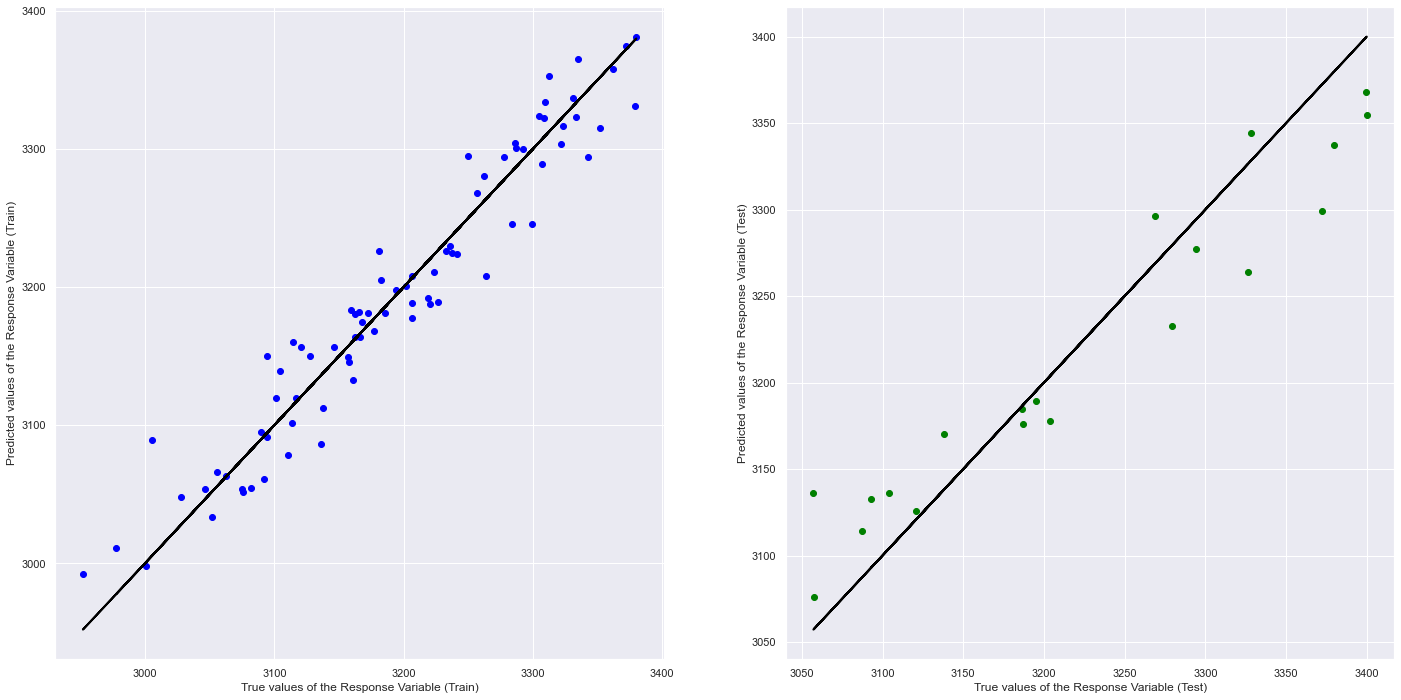

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9319575223166396
Mean Squared Error (MSE) 	: 723.625268264944

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8905591597110687
Mean Squared Error (MSE) 	: 1460.7889918355045



In [31]:
y = pd.DataFrame(tempDF["CLOSE"])
X = pd.DataFrame(tempDF[["SMA", "EMA"]])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

linreg = LinearRegression()
linreg.fit(X_train, y_train)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 2, color = "black")
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 2, color = "black")
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

We can observe the coefficients of regression we obtained. We have a coefficient of -2.260 for the SMA 3.408 for the EMA. This tells us the dependence of the closing price on each independent variable,i.e, if we were to observe the closing price by holding all the independent variables except for SMA constant, the closing price would change by a factor of 3.408.

From the regression analysis performed,we can observe that the test dataset has an R squared value of 0.890 and a Mean Squared Error of 911.381. This shows us that SMA and EMA are very good predictors of the closing price of a stock. This is in line with what we expect to see in the real world as technical indicators are generally the best predictors of the value of a particular stock.

# Sentimemtal Analysis

In [32]:
news_tables = {}


url = finwiz_url + 'AMZN'
req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
response = urlopen(req)    
# Read the contents of the file into 'html'
html = BeautifulSoup(response)
# Find 'news-table' in the Soup and load it into 'news_table'
news_table = html.find(id='news-table')
# Add the table to our dictionary
news_tables['AMZN'] = news_table

In [33]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Lets say we want to see 4 rows of data for now, printing head 4 rows:
    if i == 3:
        break

Facebook taking very aggressive measures to remove vaccine misinformation: Carolyn Everson
Apr-23-21 06:00AM  
3 Robinhood Stocks That Cathie Woods Owns -- and You Should Too
05:52AM  
Xiaomi Said to Mull Investing in AI Chipmaker Black Sesame
12:24AM  
3 Great Growth Stocks to Buy Now at a Discount
Apr-22-21 07:06PM  


In [34]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Apr-23-21',
  '06:00AM',
  'Facebook taking very aggressive measures to remove vaccine misinformation: Carolyn Everson'],
 ['AMZN',
  'Apr-23-21',
  '05:52AM',
  '3 Robinhood Stocks That Cathie Woods Owns -- and You Should Too'],
 ['AMZN',
  'Apr-23-21',
  '12:24AM',
  'Xiaomi Said to Mull Investing in AI Chipmaker Black Sesame'],
 ['AMZN',
  'Apr-22-21',
  '07:06PM',
  '3 Great Growth Stocks to Buy Now at a Discount'],
 ['AMZN',
  'Apr-22-21',
  '06:35PM',
  "Is Kroger Stock A Buy Right Now? Here's What Earnings, Charts Show"],
 ['AMZN',
  'Apr-22-21',
  '05:08PM',
  'Microsofts Big Deal and Coinbases Big Debut'],
 ['AMZN',
  'Apr-22-21',
  '03:21PM',
  'Amazon Targets Automated Checkout In Regular Supermarkets: Bloomberg'],
 ['AMZN',
  'Apr-22-21',
  '02:37PM',
  'AeroFarms Serves Up High-Growth Greens Investors Shouldnt Miss'],
 ['AMZN',
  'Apr-22-21',
  '02:30PM',
  'Top mistakes graduating college students make in trying to land a job'],
 ['AMZN',
  'Apr-22-21',
  '02

In [35]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head(20)

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-04-23,06:00AM,Facebook taking very aggressive measures to re...,0.318,0.682,0.000,-0.4927
1,AMZN,2021-04-23,05:52AM,3 Robinhood Stocks That Cathie Woods Owns -- a...,0.000,1.000,0.000,0.0000
2,AMZN,2021-04-23,12:24AM,Xiaomi Said to Mull Investing in AI Chipmaker ...,0.000,1.000,0.000,0.0000
3,AMZN,2021-04-22,07:06PM,3 Great Growth Stocks to Buy Now at a Discount,0.000,0.472,0.528,0.7717
4,AMZN,2021-04-22,06:35PM,Is Kroger Stock A Buy Right Now? Here's What E...,0.000,1.000,0.000,0.0000
5,AMZN,2021-04-22,05:08PM,Microsofts Big Deal and Coinbases Big Debut,0.000,1.000,0.000,0.0000
6,AMZN,2021-04-22,03:21PM,Amazon Targets Automated Checkout In Regular S...,0.000,0.805,0.195,0.1779
7,AMZN,2021-04-22,02:37PM,AeroFarms Serves Up High-Growth Greens Investo...,0.000,0.829,0.171,0.1139
8,AMZN,2021-04-22,02:30PM,Top mistakes graduating college students make ...,0.188,0.677,0.135,-0.1779
9,AMZN,2021-04-22,02:00PM,Amazon to Open London Hair Salon: Another Step...,0.171,0.698,0.132,-0.1280


In [36]:
parsed_and_scored_news.shape

(100, 8)

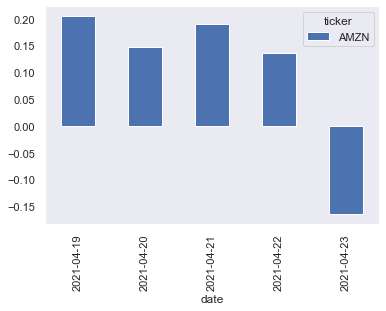

In [37]:

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
#f = plt.figure(figsize =  (12,36))
#sb.histplot(x = parsed_and_scored_news['compound'], y = parsed_and_scored_news['time'] )

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [38]:
mean_scores['Ticks'] = range(1,len(mean_scores.index.values)+1)
mean_scores


ticker,AMZN,Ticks
date,,
2021-04-19,0.204621,1
2021-04-20,0.147082,2
2021-04-21,0.189422,3
2021-04-22,0.136767,4
2021-04-23,-0.164233,5


In [39]:
lastweekclose=amzn_close[amzn_close.ticks>=96]
lastweekclose

,4. close,ticks,Rolling_Mean
date,,,
2021-04-16,3399.44,96,3378.184
2021-04-19,3372.01,97,3376.708
2021-04-20,3334.69,98,3363.646
2021-04-21,3362.02,99,3369.450
2021-04-22,3309.04,100,3355.440


In [40]:
lastwclose = pd.read_csv('Close.csv')
compound=pd.read_csv('Compound.csv')
joinDF=pd.concat([compound,lastwclose], axis = 1)
joinDF=joinDF.drop('Date',axis=1)
joinDF

,date,Compound,Close
0,18/4/2021,0.1267,3314.56
1,19/4/2021,0.2194,3372.01
2,20/4/2021,0.1471,3334.69
3,21/4/2021,0.1897,3362.02
4,22/4/2021,0.0702,3359.05


<AxesSubplot:xlabel='Date'>

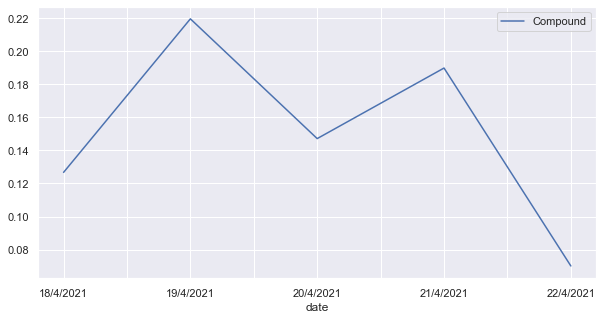

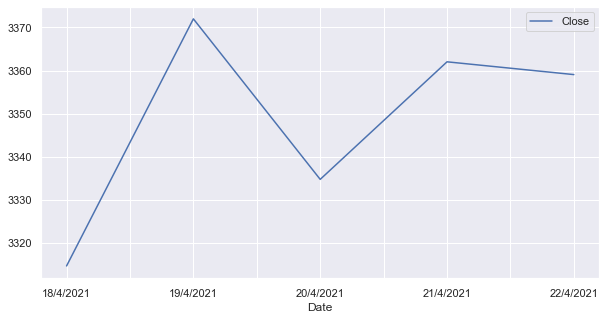

In [41]:
compound.set_index('date').plot(figsize=(10,5), grid=True)
lastwclose.set_index('Date').plot(figsize=(10,5),grid=True)

In the above plots, the first plot shows the variation of sentiments with respect to time in the last week. The second chart shows the variation of closing price with respect to time in the last week.We see a quite a strong correlation between sentiments and predicted price.